In [3]:
import bayleef
import geopandas as gpd

import plio
from plio.io.io_gdal import GeoDataset
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.animation as animation
from pylab import rcParams
import numpy as np
import gdal 
from os import path
import os
import math
import osr 
import hashlib
import pvl
from glob import glob 
import geopandas as gpd
import pandas as pd
from datetime import date
from geoalchemy2 import Geometry, WKTElement
from geoalchemy2.shape import from_shape
import shapely
from shapely.geometry import Polygon
from sqlalchemy import *
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML
import errno    
from shutil import copyfile

def geolocate(infile, outfile, lats, lons, dstSRS="EPSG:4326", format="GTiff", woptions={}, toptions={}):
    """
    """
    gdal.Translate('/vsimem/lats.vrt',lats, format="VRT", outputSRS=format, options=gdal.TranslateOptions(**toptions))
    gdal.Translate('/vsimem/lons.vrt',lons, format="VRT", outputSRS=format, options=gdal.TranslateOptions(**toptions))
    
    #Probably not neccessary
    gdal.Translate('/vsimem/image.vrt', infile, format="VRT", outputSRS=format, bandList=[48], options=gdal.TranslateOptions(**toptions))
    
    image = gdal.Open('/vsimem/image.vrt', gdal.GA_Update)
    geoloc= {
        'X_DATASET' : '/vsimem/lons.vrt',
        'X_BAND' : '1',
        'Y_DATASET' : '/vsimem/lats.vrt', 
        'Y_BAND' : '1',
        'PIXEL_OFFSET' : '0', 
        'LINE_OFFSET' : '0',
        'PIXEL_STEP' : '1',
        'LINE_STEP' : '1'
    }
    
    image.SetMetadata(geoloc, 'GEOLOCATION')
    # explicity close image 
    del image 
    
    gdal.Warp(outfile, '/vsimem/image.vrt', format=format, dstSRS=dstSRS, geoloc=True)
    return GeoDataset(outfile)

In [2]:
rcParams['figure.figsize'] = 20,20

In [3]:
!ls "/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/"
data_dir = "/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/"

# file = GeoDataset(data_dir + "MASTERL1B_1862800_01_20180201_0801_0807_V01.hdf")

ls: /work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/: No such file or directory


In [4]:
from datetime import datetime

root = "/data/sat/MASTER/derived"
somefile = "/data/sat/MASTER/2018-02-03_1862900-n/Line 02/MASTERL1B_1862900_02_20180203_0551_0600_V00.hdf"

def master(root, masterhdf):
    fd = GeoDataset(somefile)
    date = datetime.strptime(fd.metadata['CompletionDate'] , "%d-%b-%Y %H:%M:%S")
    line = fd.metadata['FlightLineNumber']
    daytime_flag = fd.metadata['day_night_flag']
    ID = fd.metadata['producer_granule_id'].split('.')[0]

    path = os.path.join(root, str(date.year), str(line), daytime_flag,ID)
    newhdf = os.path.join(path, os.path.basename(somefile))

    # Try making the directory 
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
    # copy original hdf 
    copyfile(somefile, newhdf)

    # explicitly close file descriptor 
    del fd
    
    fd = GeoDataset(newhdf)
    subdatasets = fd.dataset.GetSubDatasets()

    for dataset in subdatasets:    
        ofilename = '{}.vrt'.format(dataset[1].split()[1])
        ofilename_abspath = os.path.join(path, ofilename)
        gdal.Translate(ofilename_abspath, dataset[0], format="VRT")

    # create geo corrected calibrated image 
    lats = os.path.join(path, 'PixelLatitude.vrt')
    lons = os.path.join(path, 'PixelLongitude.vrt')
    image = os.path.join(path, 'CalibratedData.vrt')
    geocorrected_image = os.path.join(path, 'CalibratedData_Geo.tif')
    geolocate(image, geocorrected_image, lats, lons)
    
    


Geocorrecting calibrated data
Finished


In [4]:
path = '/data/sat/MASTER/derived/2018/2/N/MASTERL1B_1862900_02_20180203_0551_0600_V00/'

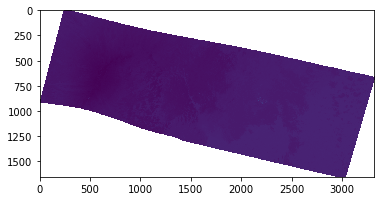

In [5]:
g = GeoDataset(path+'/CalibratedData_Geo.tif')
arr = g.read_array(48)
arr[arr==0] = np.nan
plt.imshow(arr)

In [10]:
g.metadata

{'AircraftPlatform': 'NASA ER2 (806)',
 'AltitudeCode': 'Global Pos (GPS)',
 'AREA_OR_POINT': 'Area',
 'begin_date': '20180203 055120',
 'CalibrationName': 'HawaiiVolcano_000000_072617',
 'CalibrationVersion': 'Version 1.0 Calibration',
 'CompletionDate': '03-Feb-2018 15:56:21',
 'CreationDate': '03-Feb-2018 15:56:05',
 'DataUsersGuideSource': 'http://mas.arc.nasa.gov/',
 'data_quality': 'Good',
 'data_set': 'MASTER HyspIRI_Volcano',
 'Datum': 'WGS84/NAD83',
 'day_night_flag': 'N',
 'end_date': '20180203 060001',
 'ExperimentName': 'HyspIRI_Volcano',
 'FlightComment': 'Field processing, preliminary calibration',
 'FlightDate': '03 Feb 2018',
 'FlightLineComment': 'Partly cloudy',
 'FlightLineNumber': '2',
 'FlightNumber': '18-629-00',
 'GeographicArea': 'Ramsey Volcano Line',
 'GeoLocationProcess': 'MasterGeo (3.0-D)',
 'granule_size': '329802206',
 'granule_version': '0',
 'lat_LL': '19.67282104',
 'lat_LR': '19.37491417',
 'lat_UL': '19.46074486',
 'lat_UR': '19.13799286',
 'Location

In [14]:
# print(gdal.Info(file.file_name)) 

In [6]:
# l = file.dataset.GetSubDatasets()
# print("number of sub datasets: ", len(l))
# sub = GeoDataset(l[16][0])
# print("Number of bands: ", sub.dataset.RasterCount)
# arr = sub.read_array(47)
# print(arr.shape)
# plt.imshow(arr)
# plt.colorbar()

In [7]:
# sub.file_name

In [8]:
# proj = 'PROJCS["NAD83 / UTM zone 5N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",\
#         SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],\
#         PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],\
#         AUTHORITY["EPSG","4269"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"], \
#         PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-153],PARAMETER["scale_factor",0.9996],\
#         PARAMETER["false_easting",500000],PARAMETER["false_northing",0],AUTHORITY["EPSG","26905"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'


# des_srs = proj
# src_srs = sub.dataset.GetProjection()
# options = gdal.WarpOptions(dstSRS=des_srs)

# re_proj = gdal.Warp("test.tiff", sub.file_name, options=options)

In [12]:
lons = 'HDF4_SDS:UNKNOWN:"/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/MASTERL1B_1862800_01_20180201_0801_0807_V01.hdf":31'
lats = 'HDF4_SDS:UNKNOWN:"/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/MASTERL1B_1862800_01_20180201_0801_0807_V01.hdf":30'
image = 'HDF4_SDS:UNKNOWN:"/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/MASTERL1B_1862800_01_20180201_0801_0807_V01.hdf":37'

In [2]:
somefile = "/data/sat/MASTER/2018-02-03_1862900-n/Line 02/MASTERL1B_1862900_02_20180203_0551_0600_V00.hdf"
lats = 'HDF4_SDS:UNKNOWN:"{}":30'.format(somefile)
lons = 'HDF4_SDS:UNKNOWN:"{}":31'.format(somefile)
image = 'HDF4_SDS:UNKNOWN:"{}":37'.format(somefile)

g = geolocate(image, 'test.tif', lats, lons)

translate image
set imagedata
warping


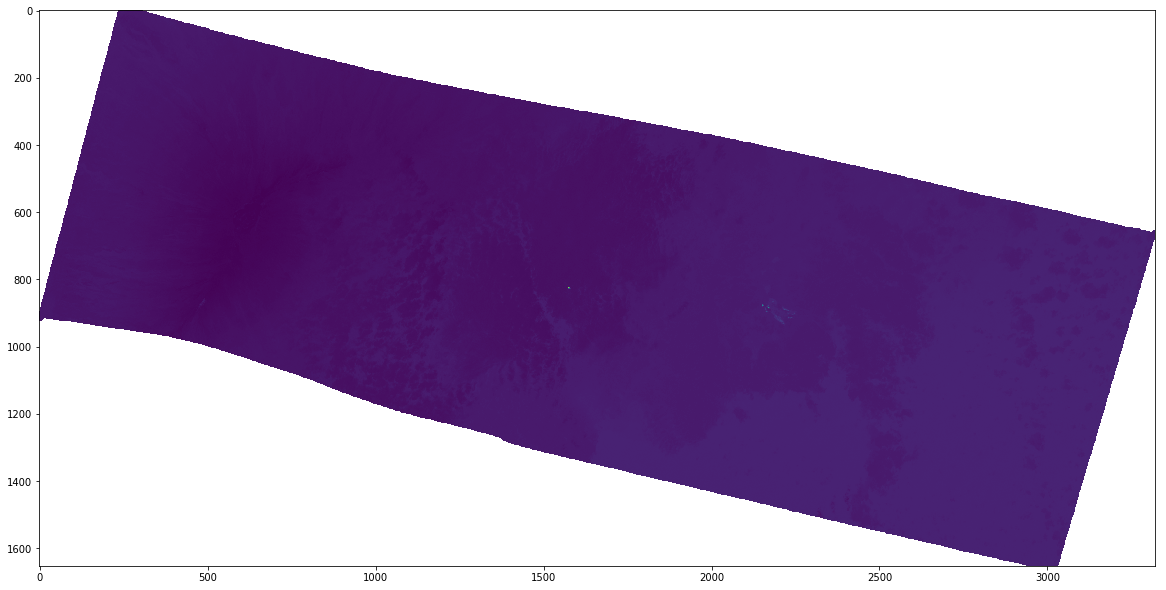

In [5]:
arr = g.read_array(48)
arr[arr == 0] = np.nan
plt.imshow(arr)

In [147]:
im = gdal.Open('image.vrt')
meta = im.GetMetadata()
geoloc= {
    'X_DATASET' : 'lon.vrt',
    'X_BAND' : '1',
    'Y_DATASET' : 'lat.vrt', 
    'Y_BAND' : '1',
    'PIXEL_OFFSET' : '0', 
    'LINE_OFFSET' : '0',
    'PIXEL_STEP' : '1',
    'LINE_STEP' : '1'
}

im.SetMetadata(geoloc, 'GEOLOCATION')
print(im.GetMetadataDomainList())
print(im.GetMetadata(domain='GEOLOCATION'))
del im

['IMAGE_STRUCTURE', '', 'GEOLOCATION', 'DERIVED_SUBDATASETS']
{'LINE_OFFSET': '0', 'LINE_STEP': '1', 'PIXEL_OFFSET': '0', 'PIXEL_STEP': '1', 'X_BAND': '1', 'X_DATASET': 'lon.vrt', 'Y_BAND': '1', 'Y_DATASET': 'lat.vrt'}


In [152]:
i = gdal.Warp('test.tif', 'image.vrt', multithread=True, format='GTiff',srcSRS="EPSG:4326", dstSRS="EPSG:4326", geoloc=True)
del i; 

(1458, 2286)


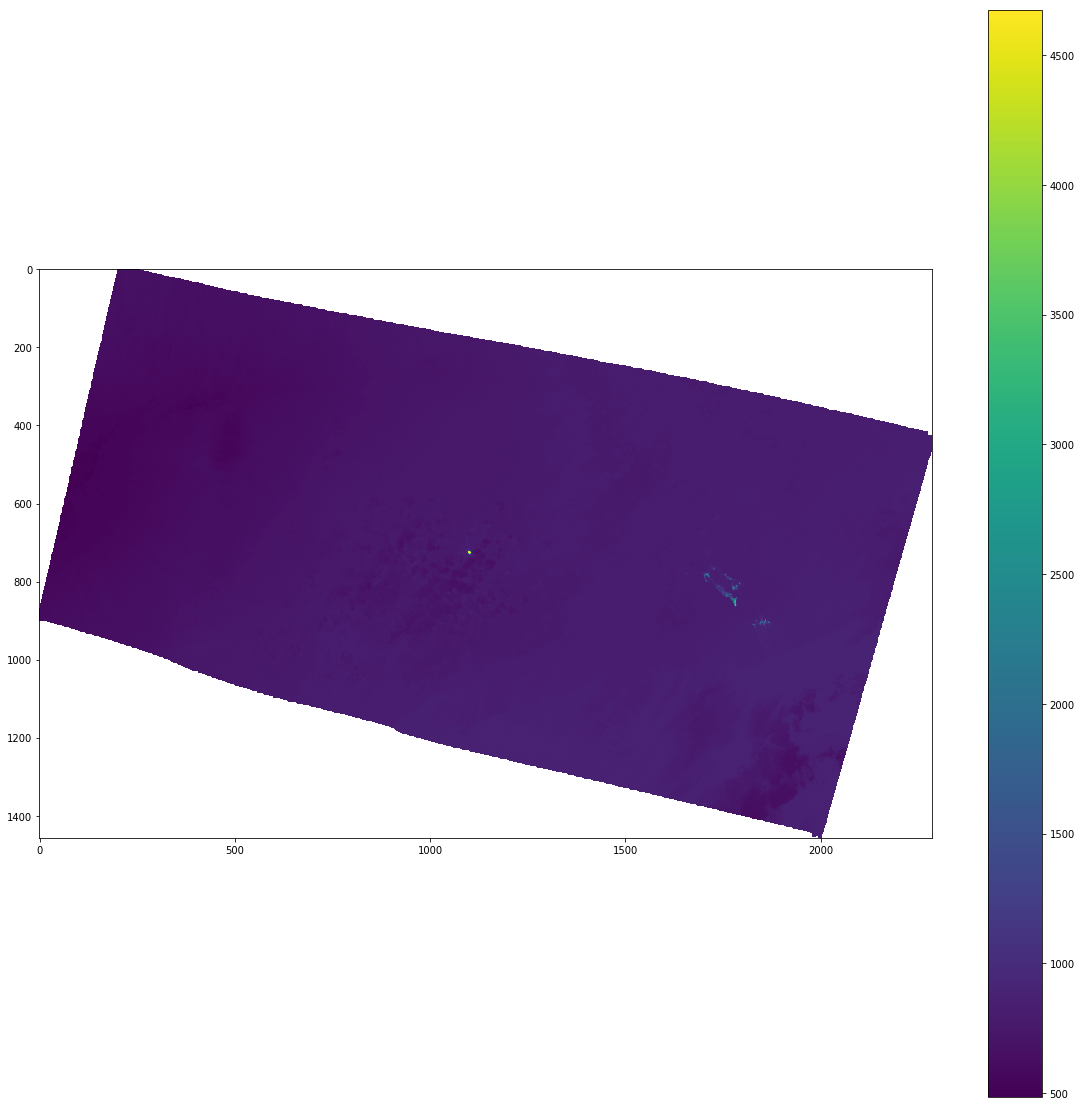

In [153]:
gds = GeoDataset('test.tif')
# print(gdal.Info('transformed.tif'))
print(gds.read_array(1).shape)
arr = gds.read_array(1)
del gds
arr[arr==0] = np.nan
plt.imshow(arr)
plt.colorbar()

In [154]:
cp test.tif ~/

In [124]:
ls -lrt ~

total 17472
drwxr-xr-x  2 krodriguez flagstaf        6 Mar  9  2016 Templates/
drwxr-xr-x  2 krodriguez flagstaf        6 Mar  9  2016 Public/
drwxr-xr-x  2 krodriguez flagstaf        6 Mar  9  2016 Music/
drwxr-xr-x  2 krodriguez flagstaf        6 Mar  9  2016 Videos/
drwxr-xr-x  2 krodriguez flagstaf     4096 Jun 30  2016 Documents/
-rw-r--r--  1 root       root           23 May 12  2017 enabled~
-rw-r--r--  1 root       root           23 May 12  2017 defrag~
-rw-r--r--  1 root       root           23 May 17  2017 defraz~
-rw-r--r--  1 root       root           23 May 17  2017 defray~
-rw-r--r--  1 root       root           23 May 17  2017 defrax~
drwxr-xr-x  5 krodriguez flagstaf     4096 May 18  2017 metastore_db/
-rwxrwxrwx  1 krodriguez flagstaf     2080 Jun  5  2017 passwd*
-rwxr-xr-x  1 krodriguez flagstaf     2080 Jun  6  2017 passwd0*
drwx------  7 krodriguez flagstaf      112 Feb  5 22:22 Library/
drwxr-xr-x  2 krodriguez flagstaf       43 Mar 21 15:31 Applications/
drwxr-xr

In [52]:
ls "/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/Geo/MASTERL1B_1862800_01_20180201_0801_0807_V00_geo_32m"

MASTERL1B_1862800_01_20180201_0801_0807_V00_geo_32m
MASTERL1B_1862800_01_20180201_0801_0807_V00_geo_32m.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V00_geo_60m
MASTERL1B_1862800_01_20180201_0801_0807_V00_geo_60m.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_32m
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_32m.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_40m
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_40m.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_50m
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_50m.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_60m
MASTERL1B_1862800_01_20180201_0801_0807_V00_GLT_60m.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V01_geo_32m
MASTERL1B_1862800_01_20180201_0801_0807_V01_geo_32m.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V01_geo_32m_NTIa
MASTERL1B_1862800_01_20180201_0801_0807_V01_geo_32m_NTIa.hdr
MASTERL1B_1862800_01_20180201_0801_0807_V01_geo_32m_NTIb
MASTERL1B_1862800_01_20180201_0801_0807_V01_geo_32m_NTIb.hdr
MASTERL1

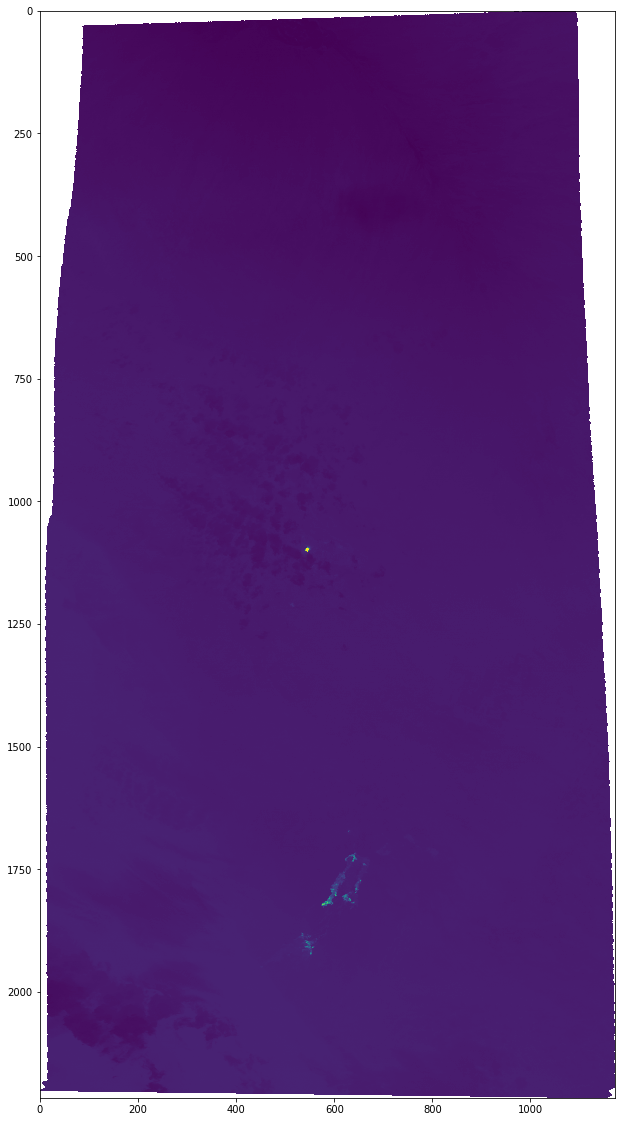

In [72]:
arr = GeoDataset("/work/users/gvaughan/Data/Hawaii/Kilauea_MaunaLoa/MASTER/2018/2018-02-01_1862800-n/Line 01/Geo/MASTERL1B_1862800_01_20180201_0801_0807_V00_geo_32m").read_array(47)
arr[arr==0] = np.nan
plt.imshow(arr)


In [7]:
i = 0
j = 1

del i,j

In [8]:
j

NameError: name 'j' is not defined